In [1]:
!pwd

/Users/efrainolivares/repos/url_classifier_develop/notebooks


In [2]:
# clean up results from staffing consulting classifier
import pandas as pd
import seaborn as sb
%matplotlib inline

In [3]:
! ls | grep 170922

05_results_170922_core_url_classified_results.ipynb


In [5]:
core_eval = pd.read_csv('data/170922_core_content_url_classication_evaluation.csv').dropna()

In [6]:
core_eval.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051347 entries, 0 to 2207598
Data columns (total 22 columns):
url                             object
end_url                         object
word_count                      float64
staffing_class                  float64
itconsult_class                 float64
nosupp_class                    float64
webhosting_count                float64
marketing_count                 float64
staffing_count                  float64
english_count                   float64
webhosting_words                object
marketing_words                 object
staffing_words                  object
english_words                   object
marketing_meta_keyword_count    float64
marketing_meta_keyword_words    object
staffing_meta_keywords_count    float64
staffing_meta_keywords_words    object
marketing_meta_desc_count       float64
marketing_meta_desc_words       object
staffing_meta_desc_count        float64
staffing_meta_desc_words        object
dtypes: float64(1

In [7]:
len(core_eval[core_eval['webhosting_count'] > 32])

30847

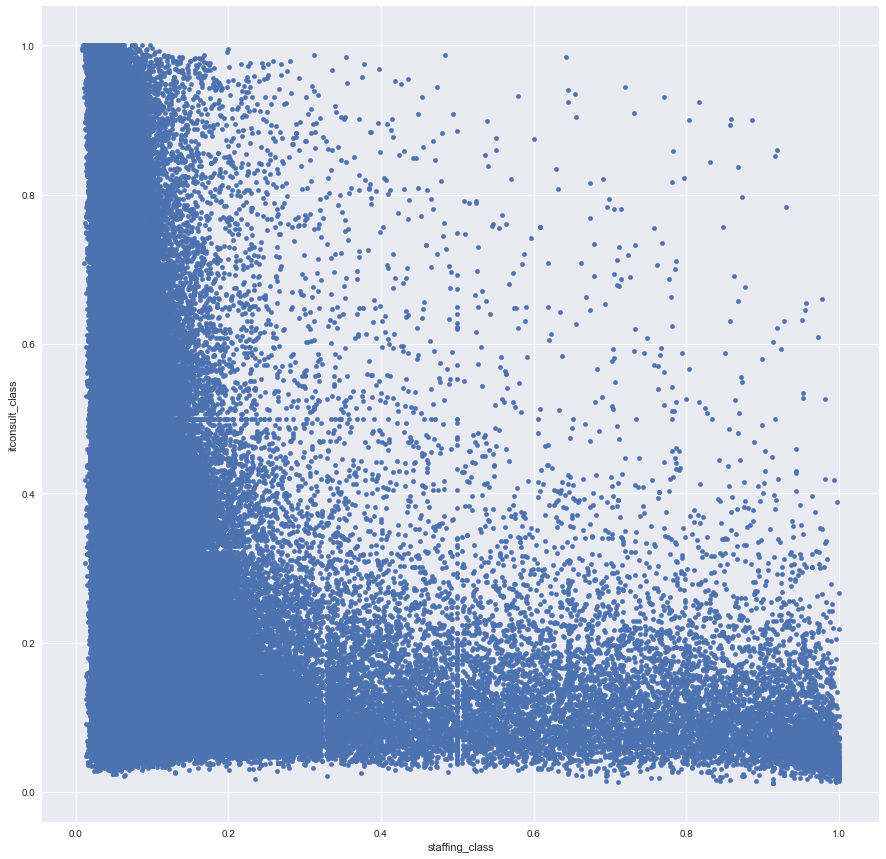

In [8]:
core_eval.plot.scatter(x='staffing_class',y='itconsult_class', figsize=(15,15))

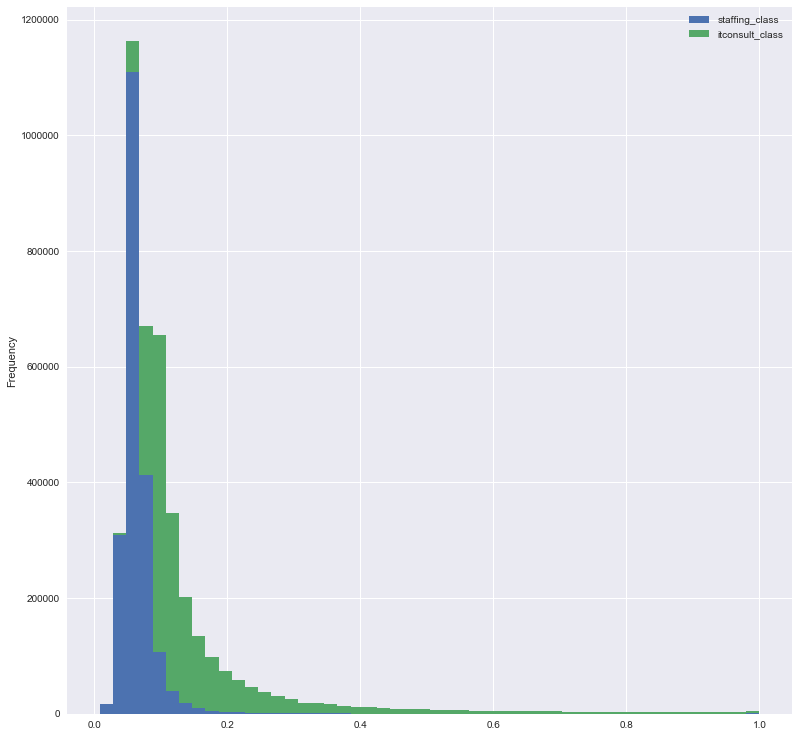

In [7]:
stafit = core_eval[['staffing_class', 'itconsult_class']]
stafit.plot.hist(stacked=True, bins=50, figsize=(13,13))

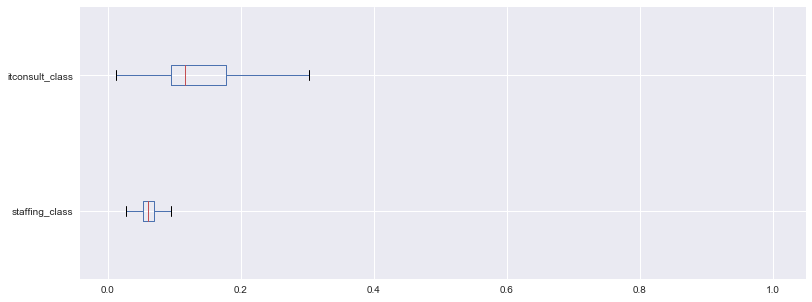

In [8]:
stafit.plot.box(vert=False, figsize=(13,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11464db10>]], dtype=object)

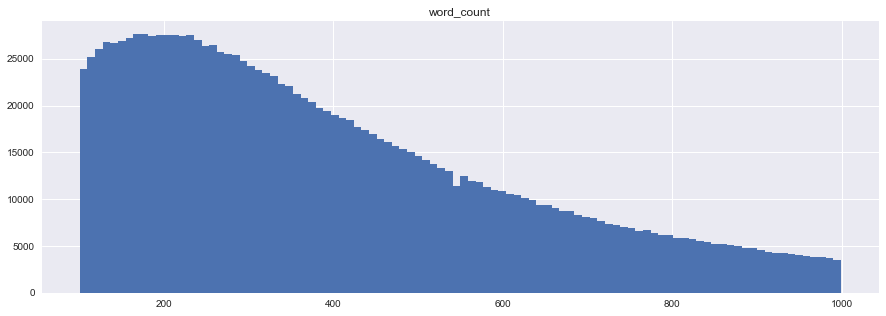

In [9]:
core_eval[(core_eval['word_count'] > 100) & (core_eval['word_count'] < 1000)].hist(column='word_count', bins=100, figsize=(15,5))

# Count by English: There are about 800k with very low english count.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11885e850>]], dtype=object)

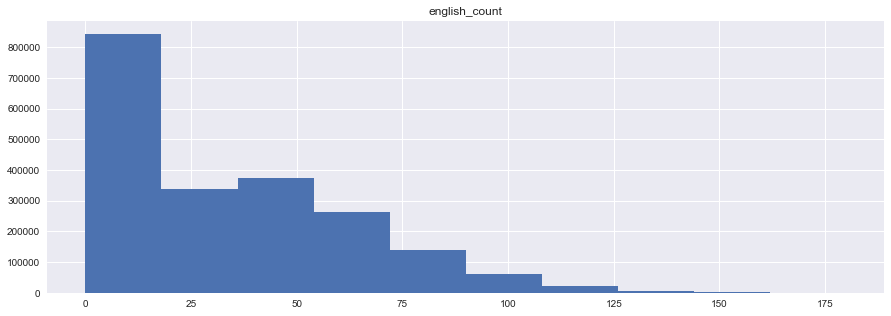

In [10]:
core_eval.hist(column='english_count', bins=10, figsize=(15,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118d1cd90>]], dtype=object)

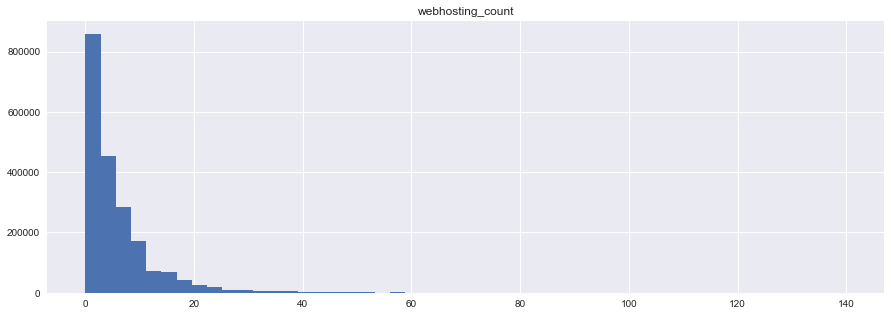

In [11]:
core_eval.hist(column='webhosting_count', bins=50, figsize=(15,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119317850>]], dtype=object)

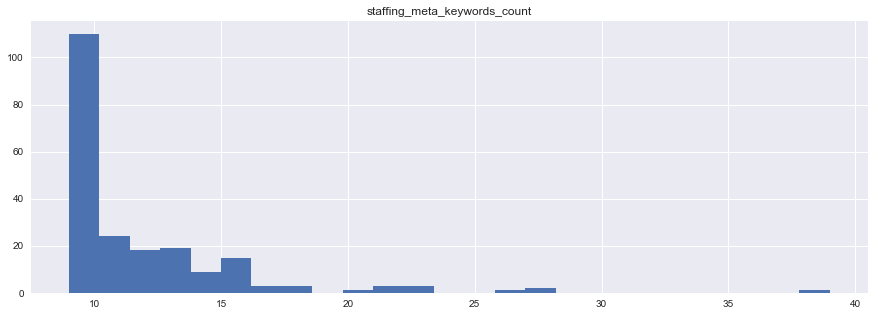

In [12]:
core_eval[core_eval['staffing_meta_keywords_count'] > 8].hist(column='staffing_meta_keywords_count', bins=25, figsize=(15,5))

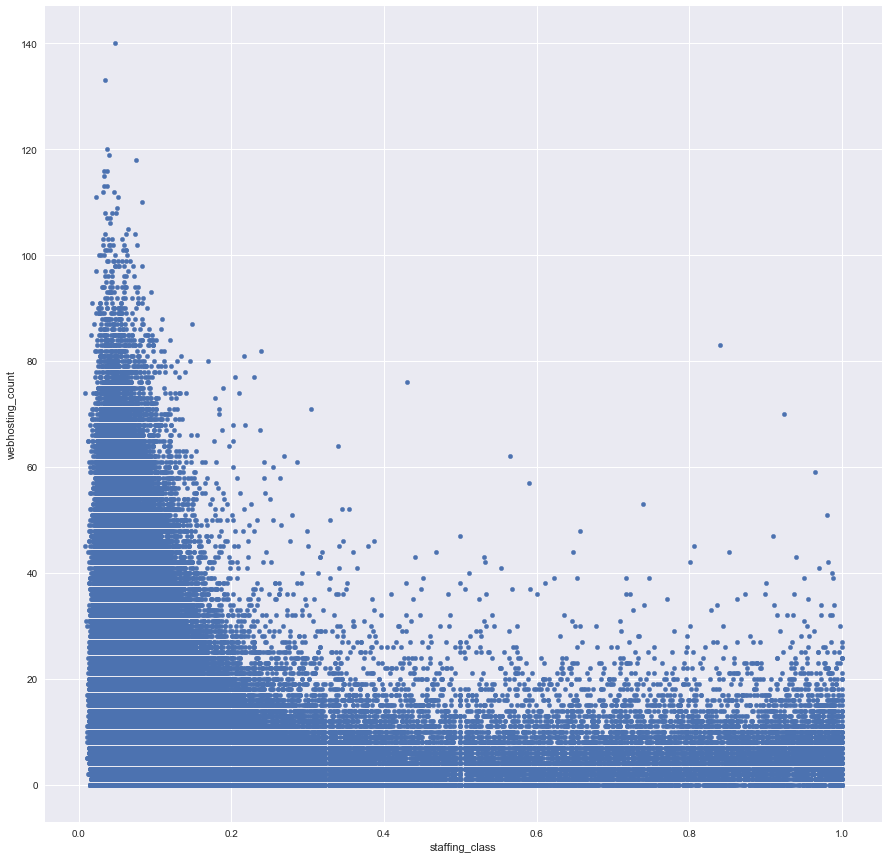

In [13]:
core_eval.plot.scatter(x='staffing_class',y='webhosting_count', figsize=(15,15))

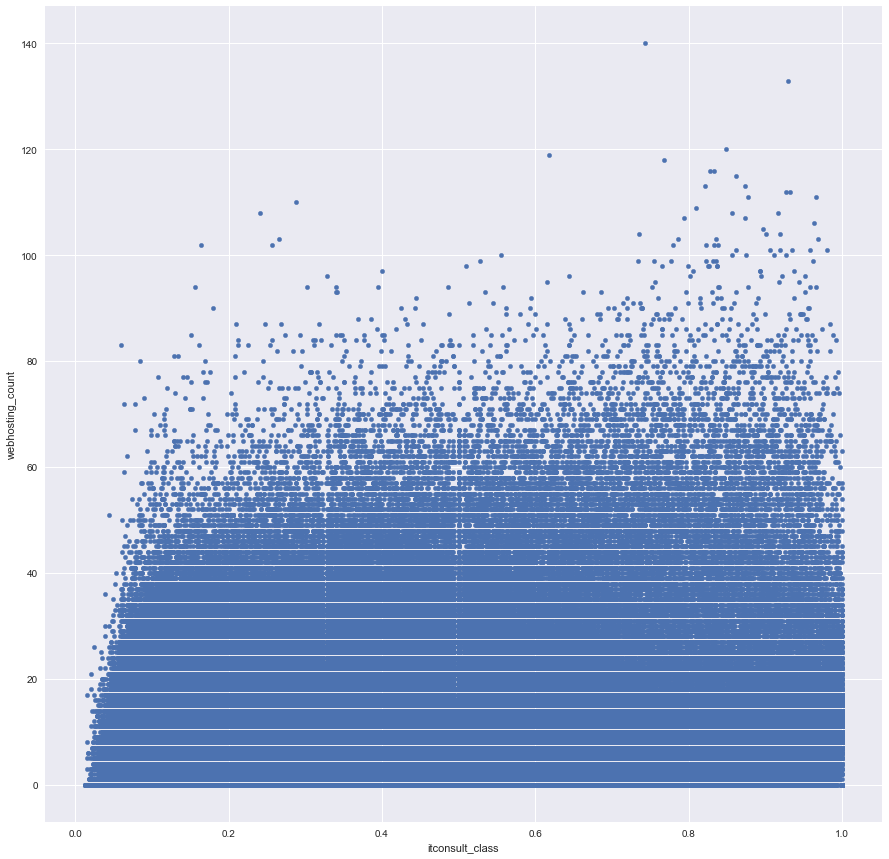

In [14]:
core_eval.plot.scatter(x='itconsult_class',y='webhosting_count', figsize=(15,15))

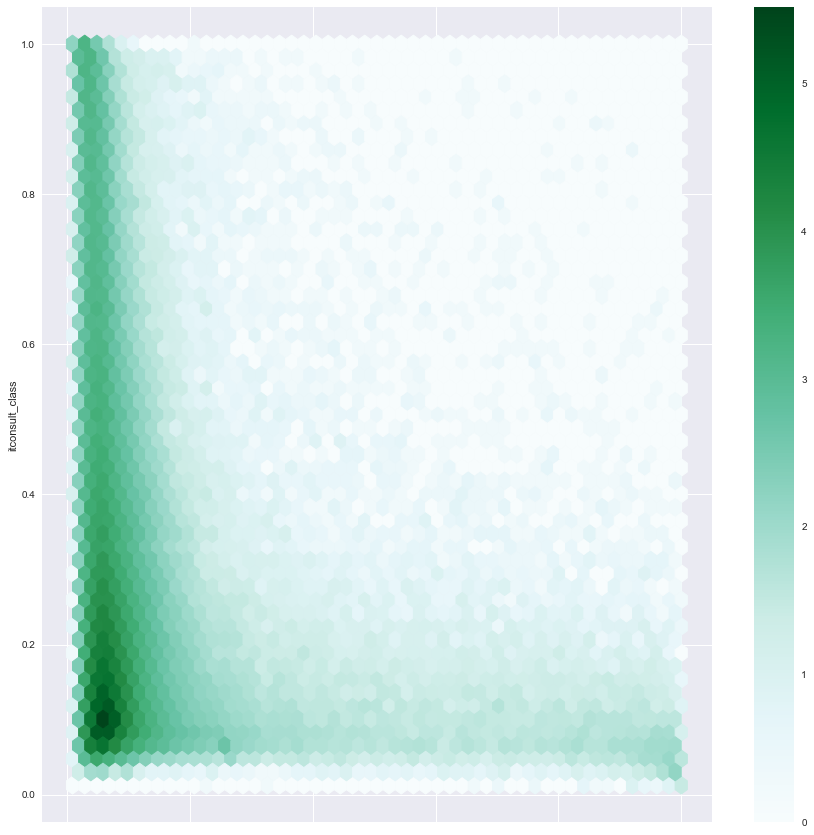

In [15]:
core_eval.plot.hexbin( x='staffing_class',y='itconsult_class', gridsize=50, figsize=(15,15),bins='log')

# Urls with an English count >= 15 is about  1.25 million

In [17]:
english15 = core_eval[core_eval['english_count'] >= 15]
len(english15)

1253630

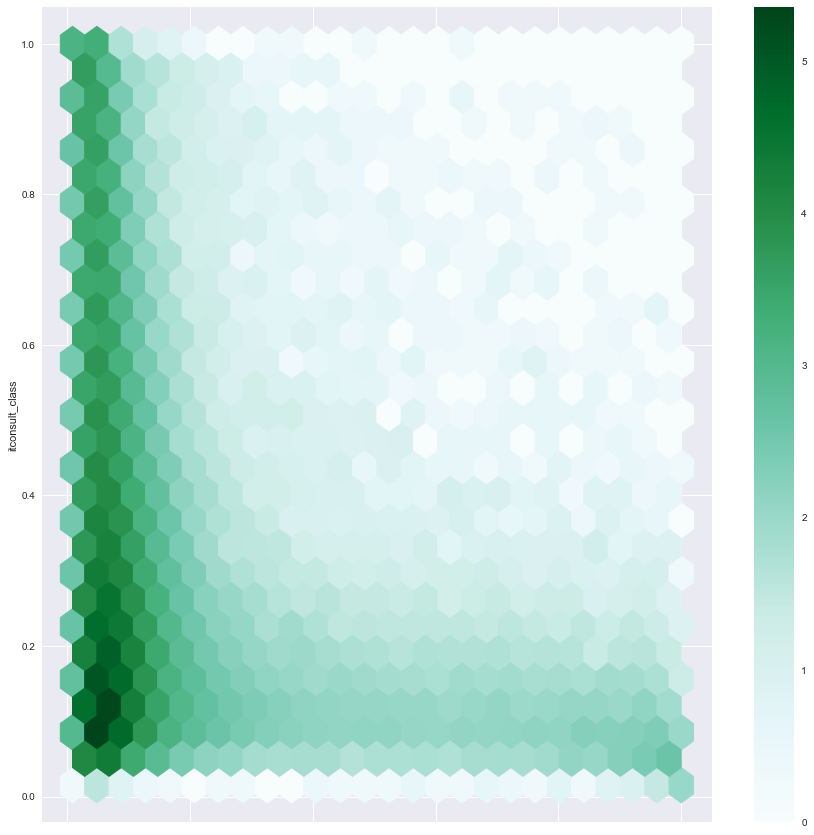

In [18]:
english15.plot.hexbin( x='staffing_class',y='itconsult_class', gridsize=25, figsize=(15,15),bins='log')

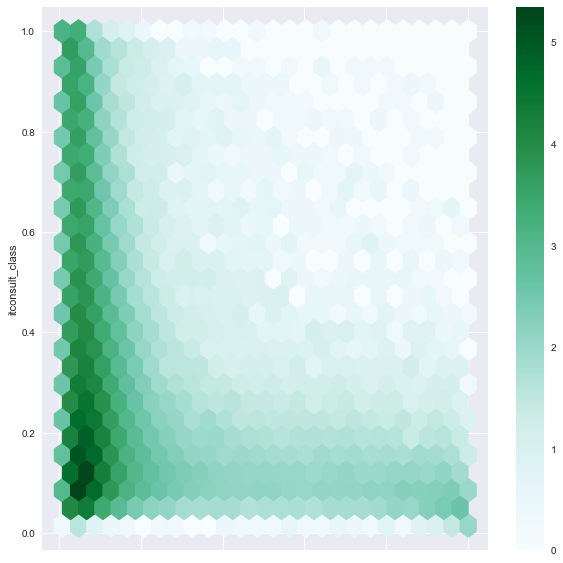

In [162]:
webhost = english15[english15['word_count'] < 10000]
webhost.plot.hexbin(x = 'staffing_class', y = 'itconsult_class', gridsize = 25, figsize = (10,10), bins = 'log')

# Target group for suppression URLS
* English >= 15
* staffing and ITC threshold >= 0.8
* webhosting filter <=32
## Suppression group to be manualy sampled is 29122 urls out of 1.25 million

## THIS IS ENGLISH ONLY

In [86]:
thold = 0.8
webthold = 32
final_suppress = core_eval[
    (core_eval['english_count'] >= 15) &
    ((core_eval['staffing_class'] >= thold) | (core_eval['itconsult_class'] >= thold)) &
    (core_eval['webhosting_count'] <= webthold)
]
len(final_suppress)

29122

In [46]:
# COUNTING THE IT CONSULT BUCKETS
# Do not take the staffing, so cut off staffing at 0.8
# break up into slots of 0.5 range from 0.8 and above
url_class = 'itconsult_class'
webthold = 32
tholds = [0.80, 0.85, 0.90, 0.95]
counts = []
for thold in tholds:
    upper_thold = thold + 0.05
    this_count = [thold, upper_thold]
    this_count.append(len(core_eval[
        (core_eval['english_count'] >= 15) &
        (core_eval[url_class] > thold) &
        (core_eval[url_class] <= upper_thold) &
        (core_eval['staffing_class'] < 0.8) &
        (core_eval['webhosting_count'] <= webthold)
    ]))
    counts.append(this_count)
    
itcon_frame = pd.DataFrame(counts)
itcon_frame

,0,1,2
0,0.80,0.85,5773
1,0.85,0.90,5873
2,0.90,0.95,6097
3,0.95,1.00,7879


In [47]:
# COUNTING THE IT CONSULT BUCKETS
# Do not take the staffing, so cut off staffing at 0.8
# break up into slots of 0.5 range from 0.8 and above
url_class = 'staffing_class'
webthold = 32
tholds = [0.80, 0.85, 0.90, 0.95]
counts = []
for thold in tholds:
    upper_thold = thold + 0.05
    this_count = [thold, upper_thold]
    this_count.append(len(core_eval[
        (core_eval['english_count'] >= 15) &
        (core_eval[url_class] > thold) &
        (core_eval[url_class] <= upper_thold) &
        (core_eval['webhosting_count'] <= webthold)
    ]))
    counts.append(this_count)
    
staff_frame = pd.DataFrame(counts)
staff_frame

,0,1,2
0,0.80,0.85,730
1,0.85,0.90,741
2,0.90,0.95,890
3,0.95,1.00,1139


In [52]:
print "ITconsulting",itcon_frame[2].sum()
print "Staffing", staff_frame[2].sum()

ITconsulting 25622
Staffing 3500


In [22]:
final_suppress.to_csv('170922_url_core_classified_filtered_15_08_32.csv')

In [23]:
final_suppress.head()

,url,end_url,word_count,staffing_class,itconsult_class,nosupp_class,webhosting_count,marketing_count,staffing_count,english_count,...,staffing_words,english_words,marketing_meta_keyword_count,marketing_meta_keyword_words,staffing_meta_keywords_count,staffing_meta_keywords_words,marketing_meta_desc_count,marketing_meta_desc_words,staffing_meta_desc_count,staffing_meta_desc_words
11,globalzone.com.au,https://globalzone.com.au/,346.0,0.030615,0.851549,0.439260,5.0,1.0,8.0,44.0,...,"--staffing--hits:8 from [u' clients ', u' solu...","--english --hits:44 from [u' for ', u' our ', ...",0.0,keywords marketing: [],0.0,keywords staffing: [],2.0,"desc marketing: [u'seo', u'design']",7.0,"desc staffing: [u'a hr', u'post', u' solutions..."
86,globaluss.ca,http://www.globaluss.com/,602.0,0.050594,0.818335,0.390478,6.0,1.0,9.0,46.0,...,"--staffing--hits:9 from [u'careers a', u' clie...","--english --hits:46 from [u' for ', u' our ', ...",0.0,keywords marketing: [],0.0,keywords staffing: [],2.0,"desc marketing: [u'seo', u'design']",8.0,"desc staffing: [u'a hr', u'post', u' clients '..."
119,globalwatchtechnologies.com,http://www.globalwatchtech.com/,1190.0,0.033453,0.964252,0.084149,12.0,2.0,24.0,81.0,...,"--staffing--hits:24 from [u'executive', u's hu...","--english --hits:81 from [u' for ', u' our ', ...",0.0,keywords marketing: [],0.0,keywords staffing: [],2.0,"desc marketing: [u'social media strategy', u'd...",26.0,"desc staffing: [u'executive', u's human', u'co..."
123,globalvillageprofessional.com,http://globalvillageprofessional.com/,197.0,0.826645,0.174848,0.187351,5.0,2.0,15.0,48.0,...,"--staffing--hits:15 from [u'a job', u'consulti...","--english --hits:48 from [u' for ', u' our ', ...",0.0,keywords marketing: [],0.0,keywords staffing: [],2.0,"desc marketing: [u'design', u'marketing']",11.0,"desc staffing: [u'a job', u'recruit', u'a hr',..."
252,globalvisseinc.com,http://globalvisseinc.com/,465.0,0.135328,0.944332,0.029180,7.0,1.0,19.0,65.0,...,"--staffing--hits:19 from [u'r resume', u'consu...","--english --hits:65 from [u' for ', u' our ', ...",0.0,keywords marketing: [],0.0,keywords staffing: [],1.0,desc marketing: [u'design'],21.0,"desc staffing: [u'r resume', u'consulting r', ..."


# Next Steps
## * Sample results to estimate % confidence in groups (0.95+, 0.9+ etc)
## * Lucia will have firmo, HG data table today, will combine to make final evaluation
## * Review DJ's alternate approach on final table
## * Process is laid out so will start cranking through German, French etc...
## * Need long term plan  on how to insert this into production.


# Open issues
## * Need to rework code so we have faster turn around, pre-process word extraction.
## * There is a set of URLS which have Unicode content, that has not been worked out.
## * There is also a set of URLs which have no content at all... but we can identify now, estimate about 10 to 15% unreachable.


# If time:
## * alternate way to create retina, use keyword filters... working on that in background towards second goal
## * we can take company's matching SIC codes and create data sets for -> keyword -> retina type approach
## * compare company name with matching urls, compare urls, can spot non-matching by type

In [69]:
final_suppress['staffing_class'].corr(final_suppress['staffing_meta_desc_count'])

0.63238800002576168

In [63]:
final_suppress['itconsult_class'].corr(final_suppress['staffing_meta_desc_count'])

-0.55188439141335666

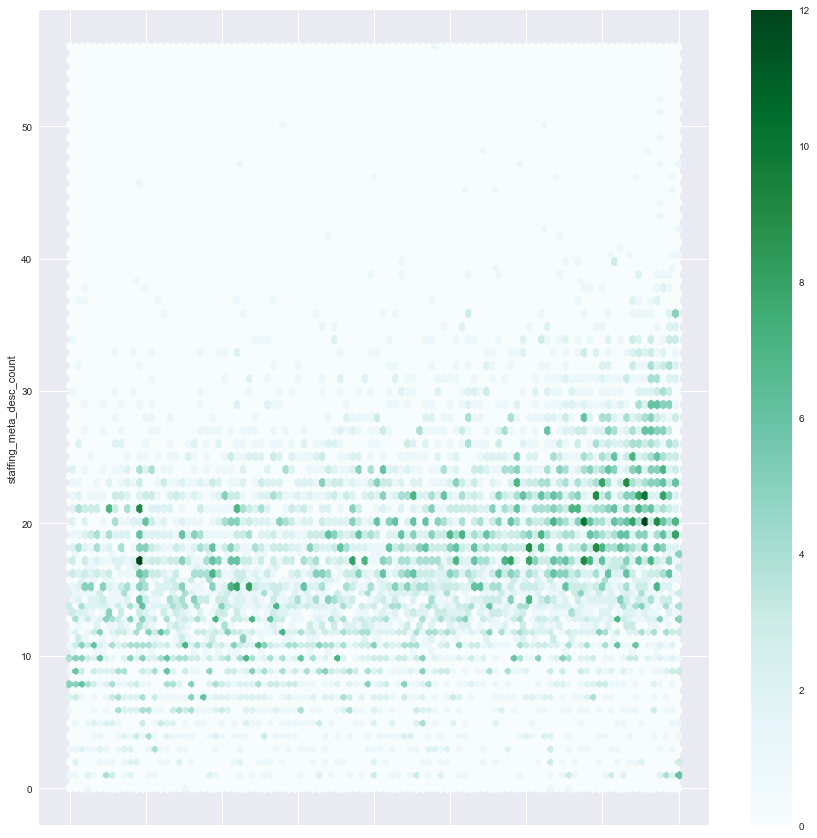

In [66]:
core_eval[core_eval['staffing_class'] >= 0.6].plot.hexbin(x='staffing_class',y='staffing_meta_desc_count', figsize=(15,15))

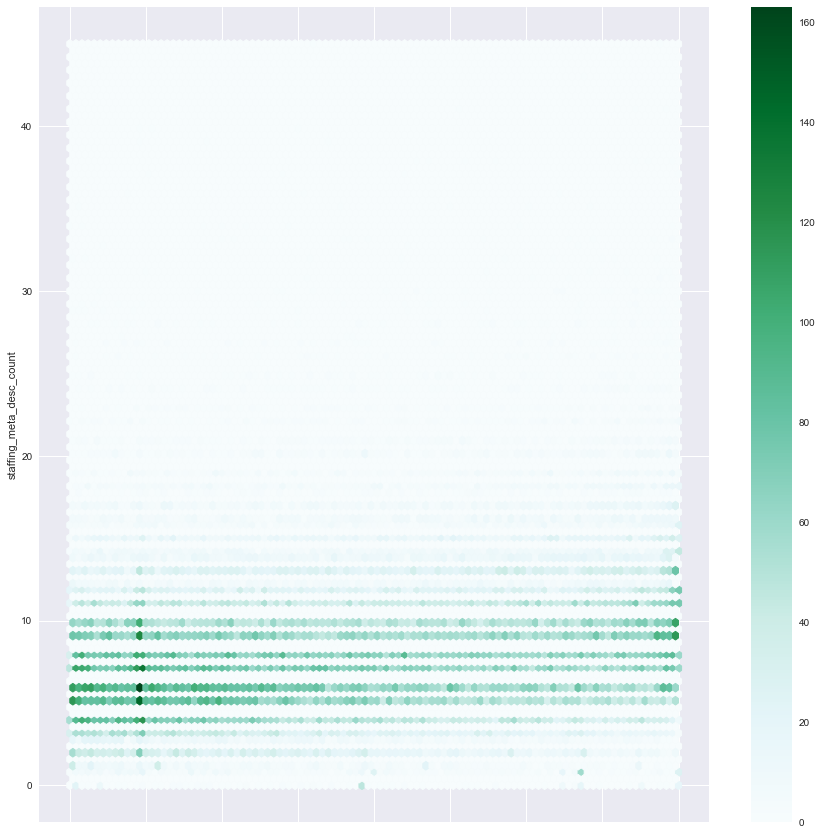

In [70]:
core_eval[core_eval['itconsult_class'] >= 0.6].plot.hexbin(x='itconsult_class',y='staffing_meta_desc_count', figsize=(15,15))

In [72]:
! ls | grep 170922

170922_core_content_url_classication_evaluation.csv
170922_core_url_classified_results.ipynb
170922_url_aggreggate_by_source_comfffuk.csv
170922_url_core_classified_filtered_15_08_32.csv


In [73]:
firmo = pd.read_csv('170922_url_aggreggate_by_source_comfffuk.csv')

/Users/efrainolivares/envnltk/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [74]:
len(firmo)

5149220

In [75]:
firmo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5149220 entries, 0 to 5149219
Data columns (total 51 columns):
url                                               object
manual_count                                      int64
manual_suppress                                   int64
manual_no_suppress                                int64
manual_most_recent_date                           float64
manual_most_recent_disposition                    object
outsourcing_count                                 int64
outsourcing_suppress                              int64
outsourcing_no_suppress                           int64
outsourcing_most_recent_date                      float64
outsourcing_most_recent_disposition               object
firmographics_industry_count                      int64
firmographics_industry_suppress                   int64
firmographics_industry_no_suppress                int64
firmographics_industry_most_recent_date           float64
firmographics_industry_most_recent_dis

In [78]:
combo = pd.merge(final_suppress, firmo, how='left', on='url')

In [79]:
len(combo)

29122

In [80]:
combo.to_csv('170922_combined_suppress_firmo.csv')

In [81]:
combo.describe()

,word_count,staffing_class,itconsult_class,nosupp_class,webhosting_count,marketing_count,staffing_count,english_count,marketing_meta_keyword_count,staffing_meta_keywords_count,...,keyword_search_suppress,keyword_search_no_suppress,keyword_search_most_recent_date,keyword_search_most_recent_disposition,approved_suppress,product_hits,revenue_min,revenue_max,employees_min,employees_max
count,29122.000000,29122.000000,29122.000000,29122.000000,29122.000000,29122.000000,29122.000000,29122.000000,29122.000000,29122.000000,...,0.0,0.0,0.0,0.0,1004.0,20041.000000,1.677800e+04,1.669000e+04,19202.000000,19151.000000
mean,534.207026,0.150084,0.812008,0.243813,11.188311,1.215473,9.614106,59.882563,0.054976,0.224847,...,NaN,NaN,NaN,NaN,1.0,23.711442,1.772279e+07,3.566351e+07,73.738517,163.608637
std,390.681106,0.283812,0.266284,0.160529,7.564476,1.368793,5.991459,22.202415,0.340232,0.962247,...,NaN,NaN,NaN,NaN,0.0,49.219793,8.905765e+07,1.110033e+08,564.286843,670.313813
min,36.000000,0.009987,0.014990,0.001856,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,1.0,0.000000,1.000000e+00,9.999990e+05,1.000000,9.000000
25%,284.000000,0.031653,0.832489,0.116461,5.000000,0.000000,6.000000,44.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,1.0,3.000000,1.000000e+06,9.999999e+06,1.000000,9.000000
50%,439.000000,0.042094,0.895373,0.211515,9.000000,1.000000,8.000000,58.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,1.0,9.000000,1.000000e+06,9.999999e+06,10.000000,49.000000
75%,668.000000,0.060337,0.954889,0.342392,16.000000,2.000000,12.000000,74.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,1.0,24.000000,1.000000e+06,9.999999e+06,10.000000,49.000000
max,9689.000000,1.000000,1.000000,0.883134,32.000000,12.000000,50.000000,146.000000,9.000000,39.000000,...,NaN,NaN,NaN,NaN,1.0,1829.000000,1.000000e+09,1.000000e+09,10000.000000,9999.000000
